In [1]:
import numpy as np
import thermo_funcs_two as tf
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize, fsolve, least_squares
from numpy.polynomial import Polynomial

In [2]:
def noise(transf,E_mids,occupf_L, occupf_R, coeff, type = "thermal"):
    plusF = occupf_L(E_mids)*(1-occupf_R(E_mids)) + occupf_R(E_mids)*(1-occupf_L(E_mids))
    occupdiff = occupf_L(E_mids) - occupf_R(E_mids)
    term_one = coeff(E_mids)**2 *(transf *plusF)
    term_two = - coeff(E_mids)**2 * transf**2*occupdiff**2
    if type == "full":
        integrands =  term_one + term_two
    elif type == "classic":
        integrands = term_one
    elif type == "quantum":
        integrands = term_two
    elif type == "thermal":
        integrands = coeff(E_mids)**2*transf*(occupf_L(E_mids)*(1-occupf_L(E_mids)) + occupf_R(E_mids)*(1-occupf_R(E_mids)))

    return np.sum(integrands)

def noise_cont(E_low,E_high,occupf_L, occupf_R, coeff, transf):
    thermal = lambda E: coeff(E)**2*transf(E)*(occupf_L(E)*(1-occupf_L(E))+ occupf_R(E)*(1-occupf_R(E)))
    shot = lambda E: coeff(E)**2 * transf(E)*(1-transf(E))*(occupf_L(E)+occupf_R(E))**2
    integrand = lambda E: thermal(E) + shot(E)
    current, err = integrate.quad(integrand, E_low, E_high, args=())
    return current

def maybe_transf(E_mids, occupf_L, occupf_R, coeff, target):
    plusF = occupf_L(E_mids)*(1-occupf_R(E_mids)) + occupf_R(E_mids)*(1-occupf_L(E_mids))
    occupdiff = occupf_L(E_mids) - occupf_R(E_mids)
    unknown_transf = lambda lamda: plusF/(2*occupdiff**2) - lamda/(2*coeff(E_mids)*occupdiff)
    func = lambda lamda: tf.slice_current_integral(unknown_transf(lamda), E_mids,occupf_L, occupf_R, coeff) - target
    res = fsolve(func, 1)
    transf = unknown_transf(res[0])
    print(res[0])
    return transf



def noise_maximize_eff(transf, E_mids,occupf_L, occupf_R, coeff_in, coeff_out, type = "full"):
    input = noise(transf, E_mids,occupf_L, occupf_R, coeff_in, type)
    output = tf.slice_current_integral(transf, E_mids,occupf_L, occupf_R, coeff_out)
    eff = output/input
    return -eff

def minimize_noise_avg(transf, E_mids,occupf_L, occupf_R, coeff_in, coeff_out, type = "thermal"):
    nois = noise(transf, E_mids,occupf_L, occupf_R, coeff_out, type)
    avg = tf.slice_current_integral(transf, E_mids,occupf_L, occupf_R, coeff_in)
    #print(nois)
    #print(avg)

    #nois = noise(transf_noise_avg, Es,occupf_L, occupf_R, coeff_out)
    #input_current = tf.slice_current_integral(transf_noise_avg, Es,occupf_L, occupf_R, coeff_in)
    #print(nois*avg)
    return nois*avg

def positive_current(transf, E_mids,occupf_L, occupf_R, coeff):
    avg = tf.slice_current_integral(transf, E_mids,occupf_L, occupf_R, coeff)
    return avg

def noise_constraint(transf, E_mids,occupf_L, occupf_R, coeff, target):
    current = tf.slice_current_integral(transf, E_mids,occupf_L, occupf_R, coeff)
    return target-current
def def_pert(E, muL, TL, muR, TR):
    E0 = tf.E_max(muL,TL,muR,TR)
    #pert = 0.5*fermi_dist(E, muL+0.1, TL + 0.1)  - 0.5*fermi_dist(E,muL,TL)
    #ratio = ((-1-E0)/(5-E0)).as_integer_ratio()
    pert = 0.1*np.sin((E - E0)*8*np.pi/(5-E0))*np.exp(-0.5*np.abs(E-E0))
    #print(type(E))
    if type(E) == np.ndarray:
        pert[E > 5] = 0
        pert[E < -1] = 0
    else:
        if E > 5:
            pert = 0
        if E < -1:
            pert = 0
    #pert = np.ones_like(E)*0.2
    #pert[E<0.2] = 0
    #pert[E>1] = 0 
    #pert[pert > 1] = 1
    #pert[pert < 0] = 0
    return pert

In [3]:
'''
T = 1
    deltaT = 0.5
    TL = T+deltaT
    TR = T-deltaT
    muR = 0
    init_muL = -1
    deltamu = init_muL-muR
    N = 1
    tf.N = N
    target_power = 0.6*tf.pmax(TL,TR)
    small_E_range = np.linspace(-1,5,100)
'''
Es = np.linspace(-1,5,100)
deltaT = 0.5
muL = -1
TR = 1-deltaT
TL = 1+deltaT
muR = 0

#occupf_L = lambda E: tf.pertub_dist(E, lambda E: tf.fermi_dist(E, muL, TL), def_pert(E, muL, TL, muR, TR))
#occupf_L = lambda E: 0.2*np.sin(4*E)+0.5
occupf_L = lambda E: tf.fermi_dist(E, muL, TL)
occupf_R = lambda E: tf.fermi_dist(E,muR, TR)

#coeff_in = lambda E: TL*tf.entropy_coeff(Es, occupf_L)
#coeff_in = lambda E: tf.entropy_coeff(E)
#coeff_in = lambda E: -(E-muL)/TL + (E-muR)/TR
coeff_in = lambda E: -tf.entropy_coeff(E, occupf_L) + (E-muR)/TR

coeff_out = lambda E: TL*tf.entropy_coeff(E, occupf_L) - E + muR
#coeff_out = lambda E: E-muL
#coeff_out = lambda E: E-muL

target = 0.5*tf.pmax(TL,TR)
print(target)

init_transf = np.random.uniform(0,1,len(Es))
res = minimize(noise_maximize_eff, init_transf, args = (Es,occupf_L, occupf_R, coeff_out, coeff_out, "full"), bounds=(((0,1),)*len(Es)),
        constraints = [{'type':'eq', 'fun': tf.slice_pow_constraint, 'args':(Es,occupf_L, occupf_R, coeff_out, target)}])
transf_noise = res.x

res = minimize(minimize_noise_avg, init_transf, args = (Es,occupf_L, occupf_R, coeff_in, coeff_out, "thermal"), bounds=(((0,1),)*len(Es)),
        constraints = [{'type':'eq', 'fun': tf.slice_pow_constraint, 'args':(Es,occupf_L, occupf_R, coeff_out, target)}])
                        #{'type':'ineq', 'fun': tf.slice_current_integral, 'args':(Es,occupf_L, occupf_R, coeff_in)}])
transf_noise_avg = res.x
print(res.message)

res = minimize(tf.slice_maximize_eff, init_transf, args = (Es,occupf_L, occupf_R, coeff_in, coeff_out), bounds=(((0,1),)*len(Es)),
        constraints = [{'type':'eq', 'fun': tf.slice_pow_constraint, 'args':(Es,occupf_L, occupf_R, coeff_out, target)}])
transf_gen = res.x




0.15840715063748417
Optimization terminated successfully


In [4]:
C_init = 0.3
C_avg = tf.general_opt__avg(C_init, target, Es[0], Es[-1],occupf_L, occupf_R, coeff_in, coeff_out)
#print(C_avg)
transf_C_avg = lambda E: tf.transmission_avg(C_avg, E, occupf_L, occupf_R, coeff_in, coeff_out)

C_noise = tf.general_opt_noise(C_init, target, Es[0], Es[-1], occupf_L, occupf_R, coeff_out)
transf_C_noise = lambda E: tf.transmission_noise(C_noise, E, occupf_L, occupf_R, coeff_out)



print(C_avg)
print(C_noise)





0.4224641288717219
0.8120266277212859


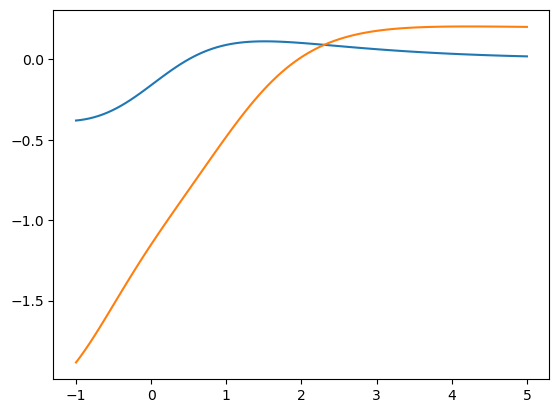

In [5]:
comp = (occupf_L(Es) - occupf_R(Es))/(coeff_out(Es)*(occupf_L(Es) *(1-occupf_L(Es)) + occupf_R(Es)*(1-occupf_R(Es))))
plt.plot(Es, coeff_out(Es)*(occupf_L(Es)- occupf_R(Es)))
plt.plot(Es, comp-C_noise)
#plt.plot(Es, coeff_out(Es))
plt.show()


In [16]:
def calc_transf(thetas,occupf_L, occupf_R, coeff_avg, coeff_nois, coeff_con, return_opt_func = False):
    term_one = lambda E: thetas[0]*coeff_nois(E)**2*(occupf_L(E)*(1-occupf_L(E))+occupf_R(E)*(1-occupf_R(E)))
    term_two = lambda E: thetas[1]*coeff_avg(E)*(occupf_L(E)-occupf_R(E))
    term_three = lambda E: -thetas[2]*coeff_con(E)*(occupf_L(E)-occupf_R(E))
    #opt_func = lambda E: x(E)**2*(fL(E)*(1-fL(E))) #+ fR(E)*(1-fR(E))) + thetas[1]*y(E)*(fL(E)-fR(E)) - thetas[2]*x(E)*(fL(E)-fR(E))
    opt_func = lambda E: term_one(E)+term_two(E)+term_three(E)

    transf_avg_nois = lambda E: np.heaviside(opt_func(E), 0)*np.heaviside(coeff_avg(E)*(occupf_L(E)-occupf_R(E)),0)*np.heaviside(coeff_con(E)*(occupf_L(E)-occupf_R(E)),0)
    if return_opt_func:
        return transf_avg_nois, opt_func
    return transf_avg_nois
    
def opt_noise_avg(thetas, E_low, E_high, occupf_L, occupf_R, coeff_avg, coeff_nois, coeff_con, target):
    fL = lambda E: occupf_L(E)
    fR = lambda E: occupf_R(E)
    x = lambda E: coeff_nois(E)
    y = lambda E: coeff_avg(E)
    transf_avg_nois = calc_transf(thetas,occupf_L, occupf_R, coeff_avg, coeff_nois, coeff_con)
    nois = noise_cont(E_low, E_high, occupf_L, occupf_R, coeff_nois, transf_avg_nois)
    avg = tf.current_integral(E_low, E_high, occupf_L, occupf_R, coeff_avg, transf_avg_nois)
    con = tf.current_integral(E_low, E_high, occupf_L, occupf_R, coeff_con, transf_avg_nois)
    
    #nois = noise(transf_avg_nois, Es, occupf_L, occupf_R, coeff_nois)
    #avg = tf.slice_current_integral(transf_avg_nois, Es, occupf_L, occupf_R, coeff_avg)
    #con = tf.slice_current_integral(transf_avg_nois, Es, occupf_L, occupf_R, coeff_nois)
    #print(nois,avg,con)
    return avg - thetas[0], nois - thetas[1], con-target

In [34]:
#input_opt = tf.slice_current_integral(transf_C_avg, Es,occupf_L, occupf_R, coeff_in)
#nois_opt = noise(transf_C_noise, Es,occupf_L, occupf_R, coeff_out)
#opt_func = lambda C: input_opt * coeff_out(Es)**2 * (occupf_L(Es)*(1-occupf_L(Es))) + nois_opt*coeff_in(Es)*(occupf_L(Es)- occupf_R(Es)) - C*coeff_out(Es)*(occupf_L(Es) - occupf_R(Es))
#transf_avg_nois_func = lambda C: np.heaviside(opt_func(C), 0)
#output_target_func = lambda C: tf.slice_current_integral(transf_avg_nois_func(C), Es,occupf_L, occupf_R, coeff_out) -target
Es = np.linspace(-1,5,100)
thetas_init = np.random.random(3)
res = fsolve(opt_noise_avg, thetas_init, factor = 1, args = (Es[0],Es[-1], occupf_L, occupf_R, coeff_in, coeff_out, coeff_out, target), full_output=True, epsfcn=None)
print(res)
thetas = res[0]
print(opt_noise_avg(thetas,Es[0], Es[-1],occupf_L, occupf_R, coeff_in, coeff_out, coeff_out, target))
transf_avg_nois, opt_func = calc_transf(thetas,occupf_L, occupf_R, coeff_in, coeff_out, coeff_out, return_opt_func=True)
#transf_noise_avg = transf_avg_nois_func(C_avg_nois)


(array([ 0.68516596,  0.51088083, -0.69980277]), {'nfev': 18, 'fjac': array([[-1.00000000e+00,  7.21644966e-16,  0.00000000e+00],
       [-7.21644966e-16, -1.00000000e+00,  0.00000000e+00],
       [-0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]), 'r': array([ 1.00000000e+00, -1.11022302e-16,  2.47587024e-16,  9.99999997e-01,
       -3.01622099e-16, -0.00000000e+00]), 'qtf': array([5.92376148e-10, 4.86253038e-10, 1.27652344e-01]), 'fvec': array([-5.92376148e-10, -4.86253038e-10,  1.27652344e-01])}, 5, 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.')
(-5.923761481341216e-10, -4.862530378346719e-10, 0.12765234445363244)


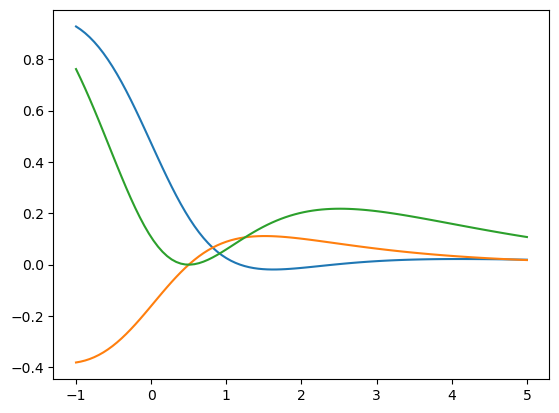

In [19]:
transfnsfnsf, opt_func = calc_transf(thetas,occupf_L, occupf_R, coeff_in, coeff_out, coeff_out, return_opt_func = True)
plt.plot(Es, opt_func(Es))
plt.plot(Es, coeff_out(Es)*(occupf_L(Es)-occupf_R(Es)))
plt.plot(Es, coeff_in(Es)*(occupf_L(Es)-occupf_R(Es)))
plt.show()

In [ ]:
'''
#Need a real integral....
cs = np.linspace(-6,-8,1000)
diffs = []
for c in cs:
    opt_func = 0.27203328419852246*x**2*(fL*(1-fL) + fR*(1-fR)) + 3.929815050207161*y*(fL-fR) - c*x*(fL-fR)
    transf_avg_nois = np.heaviside(opt_func, 0)
    con = tf.slice_current_integral(transf_avg_nois, Es, occupf_L, occupf_R, coeff_out)
    diffs.append(con-target)
plt.plot(cs, diffs)
pltshow()'
'''

"\n#Need a real integral....\ncs = np.linspace(-6,-8,1000)\ndiffs = []\nfor c in cs:\n    opt_func = 0.27203328419852246*x**2*(fL*(1-fL) + fR*(1-fR)) + 3.929815050207161*y*(fL-fR) - c*x*(fL-fR)\n    transf_avg_nois = np.heaviside(opt_func, 0)\n    con = tf.slice_current_integral(transf_avg_nois, Es, occupf_L, occupf_R, coeff_out)\n    diffs.append(con-target)\nplt.plot(cs, diffs)\npltshow()'\n"

Input current noise avg:  0.2720332841824505
Output current noise avg:  0.15840715064049504
Noise noise avg:  3.929072686229439
Efficiency noise avg:  0.5823079742486683
input * noise 1.068838546626557


Input current C noise:  0.5401625169866024
Output current C noise:  0.15840715126925828
Noise noise C:  0.16603867863035546
Efficiency noise C:  0.29325831816869147
input * noise 0.0896878705661024


Input current C avg:  0.21116093585093493
Output current C avg:  0.15840715022856386
Noise C avg:  0.3807989877165857
Efficiency C avg:  0.7501726092954446
input * noise 0.08040987061732291


Input current noise avg calc:  0.46740314364501867
Output current noise avg calc:  0.15840715095554767
Noise noise avg calc:  0.32739233706478515
Efficiency noise avg calc:  0.3389090405345114
input * noise 0.15302420754937016


S*I limit:  0.03506088276703849
Input current gen:  0.21117137857299695
Output current gen:  0.1584071506436907
Noise gen:  6.381025003883189
Efficiency gen:  0.75013551416927

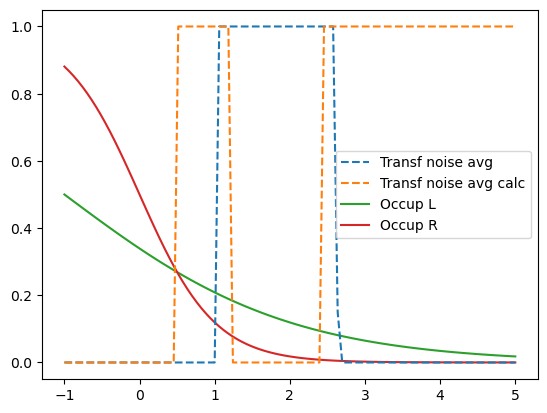

In [20]:
#transf_noise_avg = np.heaviside(occupf_L(Es)-occupf_R(Es),0)
nois = noise(transf_noise_avg, Es,occupf_L, occupf_R, coeff_out)
input_current = tf.slice_current_integral(transf_noise_avg, Es,occupf_L, occupf_R, coeff_in)
output_current = tf.slice_current_integral(transf_noise_avg, Es,occupf_L, occupf_R, coeff_out)

print("Input current noise avg: ", input_current)
print("Output current noise avg: ", output_current)
print("Noise noise avg: ", nois)
print("Efficiency noise avg: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")

nois = noise_cont(Es[0], Es[-1], occupf_L, occupf_R, coeff_out, transf_C_noise)
input_current = tf.current_integral(Es[0], Es[-1], occupf_L, occupf_R, coeff_in, transf_C_noise)
output_current = tf.current_integral(Es[0], Es[-1], occupf_L, occupf_R, coeff_out, transf_C_noise)
nois_opt = nois
print("Input current C noise: ", input_current)
print("Output current C noise: ", output_current)
print("Noise noise C: ", nois)
print("Efficiency noise C: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")

nois = noise_cont(Es[0], Es[-1], occupf_L, occupf_R, coeff_out, transf_C_avg)
input_current = tf.current_integral(Es[0], Es[-1], occupf_L, occupf_R, coeff_in, transf_C_avg)
output_current = tf.current_integral(Es[0], Es[-1], occupf_L, occupf_R, coeff_out, transf_C_avg)
avg_opt = input_current
print("Input current C avg: ", input_current)
print("Output current C avg: ", output_current)
print("Noise C avg: ", nois)
print("Efficiency C avg: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")

transf_avg_nois = calc_transf(thetas,occupf_L, occupf_R, coeff_in, coeff_out, coeff_out)
nois = noise_cont(Es[0], Es[-1], occupf_L, occupf_R, coeff_out, transf_avg_nois)
input_current = tf.current_integral(Es[0], Es[-1], occupf_L, occupf_R, coeff_in, transf_avg_nois)
output_current = tf.current_integral(Es[0], Es[-1], occupf_L, occupf_R, coeff_out, transf_avg_nois)

print("Input current noise avg calc: ", input_current)
print("Output current noise avg calc: ", output_current)
print("Noise noise avg calc: ", nois)
print("Efficiency noise avg calc: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")

print("S*I limit: ", avg_opt*nois_opt)


nois = noise(transf_gen, Es,occupf_L, occupf_R, coeff_out)
input_current = tf.slice_current_integral(transf_gen, Es,occupf_L, occupf_R, coeff_in)
output_current = tf.slice_current_integral(transf_gen, Es,occupf_L, occupf_R, coeff_out)

print("Input current gen: ", input_current)
print("Output current gen: ", output_current)
print("Noise gen: ", nois)
print("Efficiency gen: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")
nois = noise(transf_noise, Es,occupf_L, occupf_R, coeff_out)
input_current = tf.slice_current_integral(transf_noise, Es,occupf_L, occupf_R, coeff_in)
output_current = tf.slice_current_integral(transf_noise, Es,occupf_L, occupf_R, coeff_out)

print("Input current noise: ", input_current)
print("Output current noise: ", output_current)
print("Noise noise: ", nois)
print("Efficiency noise: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")




#plt.plot(Es,transf_gen, label = "Transf gen")
#plt.plot(Es, transf_noise, label = "Transf noise")
plt.plot(Es, transf_noise_avg,'--' ,label = "Transf noise avg", zorder = 3)
plt.plot(Es, transf_avg_nois(Es),'--' ,label = "Transf noise avg calc", zorder = 3)

#plt.plot(Es, transf_C_noise(Es) ,label = "Transf C noise", zorder = 2)
#plt.plot(Es, transf_C_avg(Es) ,label = "Transf C avg", zorder = 1)
#plt.plot(Es, tf.transmission_avg_avg(0.3, Es, occupf_L, occupf_R, coeff_in, coeff_out), label = "transf test")
#plt.plot(Es, transf_calc, label = "Transf calc")

plt.plot(Es, occupf_L(Es), label = "Occup L")
plt.plot(Es, occupf_R(Es), label = "Occup R")
plt.legend()
#plt.ylim([0,1])
plt.show()

In [ ]:
targets = np.linspace(0.05,0.25,10) #*tf.pmax(TL, TR)
outputs = []
turs = []
deltaT = 0.5
muL = -1
TR = 1-deltaT
TL = 1+deltaT
muR = 0
for target in targets:
        res = minimize(minimize_noise_avg, init_transf, args = (Es,occupf_L, occupf_R, coeff_in, coeff_out, "thermal"), bounds=(((0,1),)*len(Es)),
                constraints = [{'type':'eq', 'fun': tf.slice_pow_constraint, 'args':(Es,occupf_L, occupf_R, coeff_out, target)}])
                                #{'type':'ineq', 'fun': tf.slice_current_integral, 'args':(Es,occupf_L, occupf_R, coeff_in)}])
        transf_noise_avg = res.x
        nois = noise(transf_noise_avg, Es,occupf_L, occupf_R, coeff_out)
        input_current = tf.slice_current_integral(transf_noise_avg, Es,occupf_L, occupf_R, coeff_in)
        output_current = tf.slice_current_integral(transf_noise_avg, Es,occupf_L, occupf_R, coeff_out)
        tur = nois*input_current
        outputs.append(output_current)
        turs.append(tur)


49.67386639202665


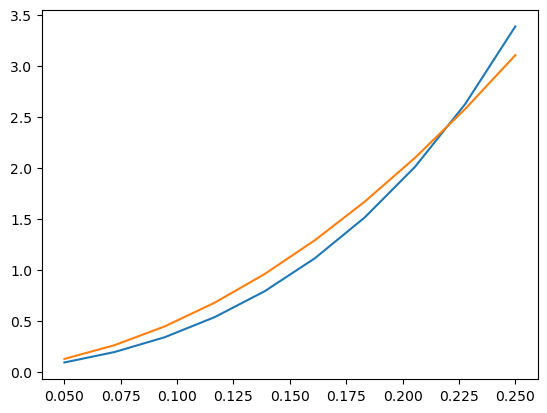

In [ ]:
outputs = np.array(outputs)
turs = np.array(turs)
#res = Polynomial.fit(outputs, turs, deg=2)
res = np.polyfit(outputs, turs, 2)
comp = np.polyval(res, outputs)
res = least_squares(lambda theta: theta*outputs**2 - turs, 1)
comp = res.x[0]*outputs**2
#comp = 70*outputs**2

print(res.x[0])
plt.plot(outputs, turs)
plt.plot(outputs, comp)
plt.show()

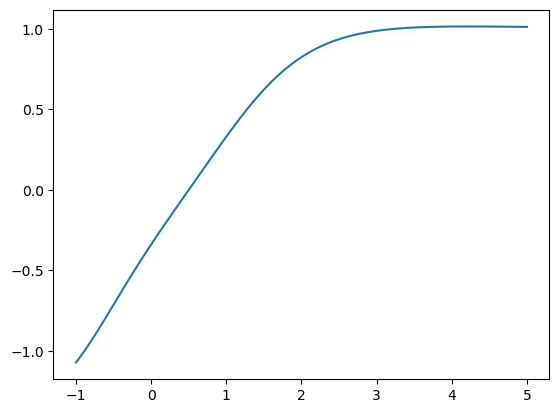

In [ ]:
nom = occupf_L(Es) - occupf_R(Es)
denom = occupf_L(Es)*(1-occupf_L(Es)) + occupf_R(Es)*(1-occupf_R(Es))
plt.plot(Es, nom/denom)
plt.show()

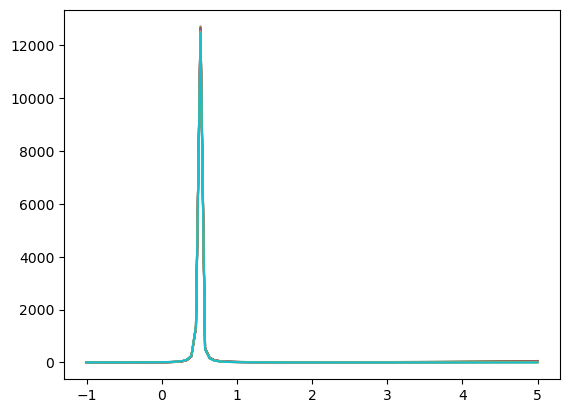

In [ ]:
plusF = occupf_L(Es)*(1-occupf_R(Es)) + occupf_R(Es)*(1-occupf_L(Es))
occupdiff = occupf_L(Es) - occupf_R(Es)
unknown_transf = lambda lamda: plusF/(2*occupdiff**2) - lamda/(2*coeff_out(Es)*occupdiff)

for lamda in np.linspace(-1,1,10):
    plt.plot(Es, unknown_transf(lamda))
#plt.ylim([0,1])
plt.show()

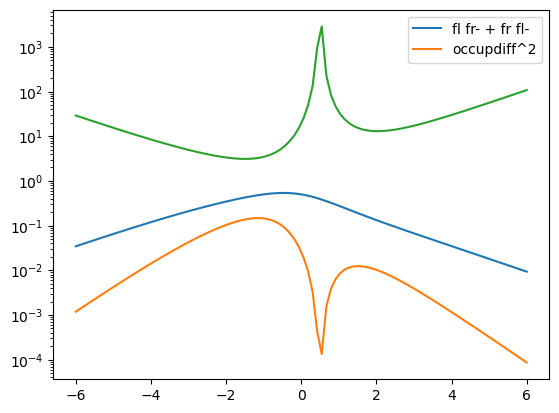

In [ ]:
o_Es = np.linspace(-6,6,100)
plusF = occupf_L(o_Es)*(1-occupf_R(o_Es)) + occupf_R(o_Es)*(1-occupf_L(o_Es))
#plt.plot(Es, occupf_L(Es)*(1-occupf_R(Es)), label = "fl fr-")
#plt.plot(Es, occupf_R(Es)*(1-occupf_L(Es)), label = "fr fl-")
plt.plot(o_Es, plusF, label = "fl fr- + fr fl-")
plt.plot(o_Es, (occupf_L(o_Es) - occupf_R(o_Es))**2, label = "occupdiff^2")
plt.plot(o_Es, plusF/(occupf_L(o_Es) - occupf_R(o_Es))**2)
plt.yscale("log")
plt.legend()
plt.show()


In [ ]:
transf_calc = maybe_transf(Es, occupf_L, occupf_R, coeff_out, target)

1.2239034706933305
